# Rotten Tomatoes Sentiment Analysis
Conducting sentiment analysis (pos/neg) on the Rotten Tomatoes dataset from HuggingFace.

## Setup

In [14]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# WordCloud
from wordcloud import WordCloud

# NLTK
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# HuggingFace
import datasets

# Transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay
)

# Progress report
from tqdm.notebook import tqdm

In [ ]:
# Setting seeds
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load Data

In [15]:
# Load train, validation, and test data
train_data, validation_data, test_data = datasets.load_dataset("rotten_tomatoes",
                                                               split=["train", "validation", "test"])
train_data, validation_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 8530
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1066
 }))

In [ ]:
# Checking data example
train_data[0]

In [ ]:
# Data features
train_data.features

In [16]:
# Changing train data into df form
train_df = pd.DataFrame(train_data)
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'id'}, inplace=True)
train_df

,id,text,label
0,0,the rock is destined to be the 21st century's ...,1
1,1,"the gorgeously elaborate continuation of "" the...",1
2,2,effective but too-tepid biopic,1
3,3,if you sometimes like to go to the movies to h...,1
4,4,"emerges as something rare , an issue movie tha...",1
...,...,...,...
8525,8525,any enjoyment will be hinge from a personal th...,0
8526,8526,if legendary shlockmeister ed wood had ever ma...,0
8527,8527,hardly a nuanced portrait of a young woman's b...,0
8528,8528,"interminably bleak , to say nothing of boring .",0


## EDA

In [ ]:
# Distribution between positive and negative reviews
sns.countplot(data=train_df, x='label')
plt.title("Distribution between pos/neg reviews")

We can see that there is an equal distribution between movies that have positive reviews and movies that have negative reviews in the training set.

In [ ]:
# Combine all text from the single column into one string
text = " ".join(train_df['text'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

## NLTK
We will use the NLTK library to conduct sentiment analysis. Specifically, we will be using the Valence Aware Dictionary and sEntiment Reasoner (VADER).

In [ ]:
# Download VADER lexicon
nltk.download('vader_lexicon')

# Create instance of Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Example
sia.polarity_scores("I am so happy!")

In [ ]:
# Another example
sia.polarity_scores("I am so sad")

In [ ]:
# Applying polarity scores to the entire train_df
results = {}
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    text = row['text']
    myid = row['id']
    results[myid] = sia.polarity_scores(text)

In [ ]:
# Displaying the result in a dataframe format
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(train_df, how='inner', left_on='id', right_on='id')
vaders

In [ ]:
# Visualize results based on different sentiments
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
sns.barplot(data=vaders, x='label', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='label', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='label', y='neg', ax=axs[2])
sns.barplot(data=vaders, x='label', y='compound', ax=axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()

The graph indicates that the mean compound score for negative sentiment labels are less than 0.05 while the mean compound score for positive sentiment labels are slightly above 0.3.

The graphs above show that the VADER polarity scores are consistent with the labelling of positive and negative movie review sentiments.

In [ ]:
# Assigning labels based on VADERS results
vader_labels = {}
for index, row in tqdm(vaders.iterrows(), total=len(vaders)):
    if row['compound'] > 0:
        label = 1
    else:
        label = 0

    vader_labels[index] = label

In [ ]:
vaders['vader_labels'] = pd.Series(vader_labels)
vaders

In [ ]:
# Assign lables
y_true = vaders['label']
y_pred = vaders['vader_labels']

# Classification metrics
accuracy = round(accuracy_score(y_true, y_pred), 4)
precision = round(precision_score(y_true, y_pred), 4)
recall = round(recall_score(y_true, y_pred), 4)
f1 = round(f1_score(y_true, y_pred), 4)
roc_auc = round(roc_auc_score(y_true, y_pred), 4)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:\n", report)

# Confusion matrix
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

As we can see, the VADERS model does not give a satisfactory result.

# BERT (unused)

In [17]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.


In [ ]:
# Import Tensorflow
import torch

# Setting up BERT model
MODEL = f"nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = model.to(device)

# Function to get polarity scores using BERT model
def polarity_scores_bert(text):
    encoded_text = tokenizer.encode(text, return_tensors='pt')
    output = model(encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'bert_1_star' : scores[0],
        'bert_2_star' : scores[1],
        'bert_3_star' : scores[2],
        'bert_4_star' : scores[3],
        'bert_5_star' : scores[4]
    }
    return scores_dict

# Running the BERT model on the entire train_df dataset
res = {}
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        text = row['text']
        myid = row['id']
        bert_result = polarity_scores_bert(text)
        res[myid] = bert_result
    except RuntimeError:
        print(f'Broke for id {myid}')

# Displaying the result in a dataframe format
bert = pd.DataFrame(res).T
bert

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/Users/Anaqi_Amir/opt/anaconda3/envs/rotten_tomatoes/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

  0%|          | 0/8530 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,bert_1_star,bert_2_star,bert_3_star,bert_4_star,bert_5_star
0,0.032359,0.106020,0.264506,0.392059,0.205056
1,0.045276,0.131448,0.186256,0.362144,0.274876
2,0.037943,0.157530,0.479475,0.280569,0.044483
3,0.021029,0.086984,0.418414,0.373449,0.100125
4,0.326898,0.445699,0.156506,0.048475,0.022423
...,...,...,...,...,...
8525,0.493445,0.391335,0.083159,0.020848,0.011213
8526,0.291502,0.397941,0.208780,0.074290,0.027486
8527,0.018334,0.260069,0.635084,0.083141,0.003372
8528,0.577798,0.358592,0.054986,0.005403,0.003222


In [19]:
# Assigning labels based on VADERS results
bert_labels = {}
for index, row in tqdm(bert.iterrows(), total=len(bert)):
    neg = row['bert_1_star'] + row['bert_2_star'] + (row['bert_3_star'] / 2)
    pos = row['bert_4_star'] + row['bert_5_star'] + (row['bert_3_star'] / 2)
    label = 1 if pos >= neg else 0
    bert_labels[index] = label

# Create prediction column
bert['bert_labels'] = pd.Series(bert_labels)
bert

  0%|          | 0/8530 [00:00<?, ?it/s]

,bert_1_star,bert_2_star,bert_3_star,bert_4_star,bert_5_star,bert_labels
0,0.032359,0.106020,0.264506,0.392059,0.205056,1
1,0.045276,0.131448,0.186256,0.362144,0.274876,1
2,0.037943,0.157530,0.479475,0.280569,0.044483,1
3,0.021029,0.086984,0.418414,0.373449,0.100125,1
4,0.326898,0.445699,0.156506,0.048475,0.022423,0
...,...,...,...,...,...,...
8525,0.493445,0.391335,0.083159,0.020848,0.011213,0
8526,0.291502,0.397941,0.208780,0.074290,0.027486,0
8527,0.018334,0.260069,0.635084,0.083141,0.003372,0
8528,0.577798,0.358592,0.054986,0.005403,0.003222,0


Accuracy: 0.7817
Precision: 0.7577
Recall: 0.8284
F1 Score: 0.7914
ROC-AUC Score: 0.7817
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77      4265
           1       0.76      0.83      0.79      4265

    accuracy                           0.78      8530
   macro avg       0.78      0.78      0.78      8530
weighted avg       0.78      0.78      0.78      8530



<Axes: >

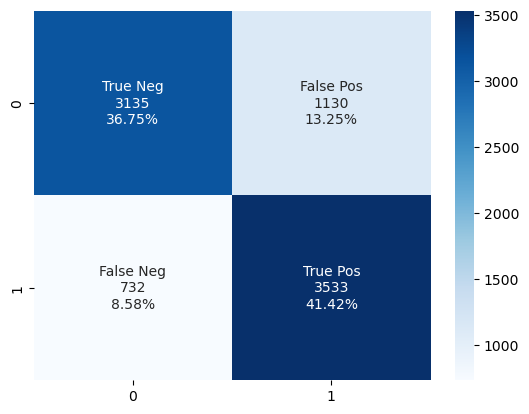

In [20]:
# Assign labels
y_true = train_df['label']
y_pred = bert['bert_labels']

# Classification metrics
accuracy = round(accuracy_score(y_true, y_pred), 4)
precision = round(precision_score(y_true, y_pred), 4)
recall = round(recall_score(y_true, y_pred), 4)
f1 = round(f1_score(y_true, y_pred), 4)
roc_auc = round(roc_auc_score(y_true, y_pred), 4)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:\n", report)

# Confusion matrix
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

## ROBERTA

In [21]:
# Setting up ROBERTA model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = model.to(device)

/Users/Anaqi_Amir/opt/anaconda3/envs/rotten_tomatoes/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
# Function to get polarity scores using Roberta model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [23]:
# Running the model on the entire train_df dataset
res = {}
for index, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        text = row['text']
        myid = row['id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/8530 [00:00<?, ?it/s]

In [24]:
# Displaying the result in a dataframe format
roberta = pd.DataFrame(res).T
roberta

,roberta_neg,roberta_neu,roberta_pos
0,0.002251,0.078215,0.919535
1,0.024806,0.225588,0.749606
2,0.636203,0.339475,0.024322
3,0.002743,0.076569,0.920688
4,0.090276,0.525855,0.383869
...,...,...,...
8525,0.114693,0.432905,0.452402
8526,0.370913,0.561094,0.067993
8527,0.264912,0.635328,0.099759
8528,0.856152,0.125944,0.017904


In [25]:
# Assigning labels based on VADERS results
roberta_labels = {}
for index, row in tqdm(roberta.iterrows(), total=len(roberta)):
    pos = row['roberta_pos'] + (row['roberta_neu'] / 2)
    neg = row['roberta_neg'] + (row['roberta_neu'] / 2)
    label = 1 if pos >= neg else 0

    roberta_labels[index] = label

  0%|          | 0/8530 [00:00<?, ?it/s]

In [26]:
roberta['roberta_labels'] = pd.Series(roberta_labels)
roberta

,roberta_neg,roberta_neu,roberta_pos,roberta_labels
0,0.002251,0.078215,0.919535,1
1,0.024806,0.225588,0.749606,1
2,0.636203,0.339475,0.024322,0
3,0.002743,0.076569,0.920688,1
4,0.090276,0.525855,0.383869,1
...,...,...,...,...
8525,0.114693,0.432905,0.452402,1
8526,0.370913,0.561094,0.067993,0
8527,0.264912,0.635328,0.099759,0
8528,0.856152,0.125944,0.017904,0


Accuracy: 0.7941
Precision: 0.8104
Recall: 0.7679
F1 Score: 0.7886
ROC-AUC Score: 0.7941
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      4265
           1       0.81      0.77      0.79      4265

    accuracy                           0.79      8530
   macro avg       0.79      0.79      0.79      8530
weighted avg       0.79      0.79      0.79      8530



<Axes: >

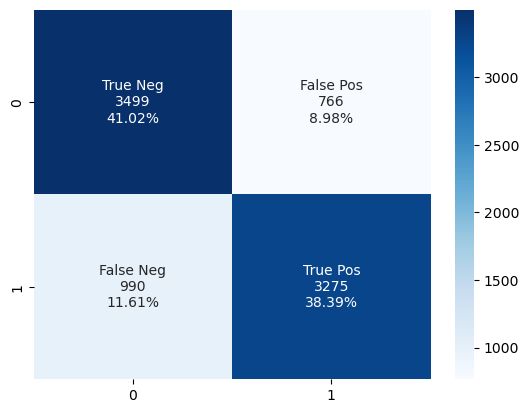

In [27]:
# Assign labels
y_true = train_df['label']
y_pred = roberta['roberta_labels']

# Classification metrics
accuracy = round(accuracy_score(y_true, y_pred), 4)
precision = round(precision_score(y_true, y_pred), 4)
recall = round(recall_score(y_true, y_pred), 4)
f1 = round(f1_score(y_true, y_pred), 4)
roc_auc = round(roc_auc_score(y_true, y_pred), 4)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:\n", report)

# Confusion matrix
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

# BERT

In [29]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Layer
from keras.layers import (
        Dense,
        Flatten,
        InputLayer,
        BatchNormalization,
        Dropout,
        Input,
        LayerNormalization)
from keras.losses import (
        BinaryCrossentropy,
        CategoricalCrossentropy,
        SparseCategoricalCrossentropy)
from keras.metrics import (
    Accuracy,
    TopKCategoricalAccuracy,
    CategoricalAccuracy,
    SparseCategoricalAccuracy)
from keras.optimizers import Adam
# from google.colab import drive
# from google.colab import files
from transformers import BertTokenizerFast, TFBertForSequenceClassification
# (
#     BertTokenizerFast,
#     TFBertTokenizer,
#     BertTokenizer,
#     RobertaTokenizerFast,
#     DataCollatorWithPadding,
#     TFRobertaForSequenceClassification,
#     TFBertForSequenceClassification,
#     TFBertModel,
#     create_optimizer)

In [30]:
# Initialize model and tokernizer
MODEL="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL)

/Users/Anaqi_Amir/opt/anaconda3/envs/rotten_tomatoes/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
# Function to tokenize text in data
def preprocess_function(data):
  return tokenizer(data["text"],padding=True,truncation=True)

# Tokenizing train data
tokenized_dataset = train_data.map(preprocess_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8530
})

In [32]:
# Visualize tokenized_dataset
pd.DataFrame({
    'text':tokenized_dataset[:5]['text'],
    'label':tokenized_dataset[:5]['label'],
    'input_ids':tokenized_dataset[:5]['input_ids'],
    'token_type_ids':tokenized_dataset[:5]['token_type_ids'],
    'attention_mask':tokenized_dataset[:5]['attention_mask']
    })

,text,label,input_ids,token_type_ids,attention_mask
0,the rock is destined to be the 21st century's ...,1,"[101, 1996, 2600, 2003, 16036, 2000, 2022, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"the gorgeously elaborate continuation of "" the...",1,"[101, 1996, 9882, 2135, 9603, 13633, 1997, 100...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,effective but too-tepid biopic,1,"[101, 4621, 2021, 2205, 1011, 8915, 23267, 160...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,if you sometimes like to go to the movies to h...,1,"[101, 2065, 2017, 2823, 2066, 2000, 2175, 2000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"emerges as something rare , an issue movie tha...",1,"[101, 19391, 2004, 2242, 4678, 1010, 2019, 327...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [33]:
from transformers import DataCollatorWithPadding

# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Convert to tensorflow formatted df
tf_train_dataset = tokenized_dataset.to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask", "label"],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=True
)

In [34]:
# Reformat dataset
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask']
          } , dataset['label']

# Execution
tf_train_dataset = tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

KeyError: in user code:

    File "/var/folders/5q/n8ssmgtj6nd825347vg7wz240000gn/T/ipykernel_71736/404505314.py", line 3, in swap_positions  *
        return {'input_ids':dataset['input_ids'],

    KeyError: 'label'


In [35]:
# Check
for i in tf_train_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(8, 73), dtype=int64, numpy=
array([[  101,  1037,  2843,  1997,  4569,  1010,  2007,  2019,  6151,
        19825,  3468,  2943, 13977,  2011,  2048, 19910,  1999,  2037,
         2753,  2015,  2551,  2012,  1996,  4672,  1997,  2037,  4204,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  101,  1037, 17743,  2176,  2086,  1999,  1996,  2437,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,


2024-11-29 14:21:52.284057: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Training setup
num_epochs = 3
batches_per_epoch = len(tokenized_dataset) // 8
total_train_steps = int(batches_per_epoch * num_epochs)

# Optimizer
# optimizer, schedule = create_optimizer(init_lr=2e-5,
#                                        num_warmup_steps=0,
#                                        num_train_steps=total_train_steps)

# Optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='adam'
)

In [38]:
# Compile
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)

In [39]:
# Prep testing set

# Tokenizing train data
tokenized_test_dataset = test_data.map(preprocess_function, batched=True)

# Convert to tensorflow formatted df
tf_test_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask", "label"],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=True
)

# Swap column positions
#tf_test_dataset = tf_test_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# import tensorflow_addons as tfa

# # initialize tqdm callback with default parameters
# tqdm_callback = tfa.callbacks.TQDMProgressBar()

# Model training with TQDM progress bar
history = model.fit(
    tf_train_dataset.take(1000),
    validation_data=tf_test_dataset,
    epochs=3,
    verbose = 100
    # callback = tqdm_callback
)


Epoch 1/3


In [ ]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()